In [ ]:
import jax
import jax.numpy as jnp
from jax import config
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, evolve_perturbations_batched, get_power
import matplotlib.pyplot as plt
# plt.style.use('~/.mplstyles/mystyle.mplstyle')

config.update("jax_enable_x64", True)
dtype = jnp.float64

In [ ]:
!pip list | grep -E 'jax|numpy|diffrax'

cosmopower_jax                    0.5.5
diffrax                           0.7.0
jax                               0.5.0
jax_autovmap                      0.2.1
jax-cosmo                         0.1.0
jax-cuda12-pjrt                   0.5.0
jax-cuda12-plugin                 0.5.0
jax-tqdm                          0.1.1
jaxlib                            0.5.0
jaxopt                            0.6
jaxtyping                         0.2.34
numpy                             1.26.4


### Power spectrum function

In [2]:
# @jax.jit
def compute_matter_power(Omegam=0.3):
    param = {}
    param['Omegam'] = Omegam
    param['Omegab'] = 0.05
    param['w_DE_0'] = -0.99
    param['w_DE_a'] = 0.0
    param['cs2_DE'] = 0.99  # sound speed of DE
    param['Omegak'] = 0.0  # NOTE: Omegak is ignored at the moment!
    param['A_s'] = 2.1e-9
    param['n_s'] = 0.96
    param['H0'] = 67.74  # Hubble constant in km/s/Mpc
    param['Tcmb'] = 2.72548  # CMB temperature in K
    param['YHe'] = 0.248
    Neff = 3.046  # -1 if massive neutrino present
    N_nu_mass = 1.0
    Tnu = (4.0 / 11.0) ** (1.0 / 3.0)
    N_nu_rel = Neff - N_nu_mass * (Tnu / ((4.0 / 11.0) ** (1.0 / 3.0))) ** 4
    param['Neff'] = N_nu_rel
    param['Nmnu'] = N_nu_mass
    param['mnu'] = 0.06  # eV
    param['k_p'] = 0.05  # pivot scale for the primordial power spectrum in Mpc^-1
    param_bg = evolve_background(param=param, thermo_module='RECFAST')

    # Compute perturbations
    y, kmodes = evolve_perturbations(param=param_bg, kmin=1e-5, kmax=1e1, num_k=256,
                        aexp_out=jnp.array([1.0]), lmaxg=11, lmaxgp=11, lmaxr=11, lmaxnu=11,
                        nqmax=3, max_steps=2048, rtol=1e-4, atol=1e-4)

    # Get the power spectrum at z=0
    Pk = get_power(k=kmodes, y=y[:, 0, :], idx=4, param=param_bg)

    # Convert to /h units
    h = param['H0'] / 100.0
    Pk_in_Mpc_h = Pk * h ** 3
    kmodes_in_Mpc_h = kmodes / h
    return Pk_in_Mpc_h, kmodes_in_Mpc_h

In [5]:
Omegam_fid = 0.3
Pk_in_Mpc_h, kmodes_in_Mpc_h = compute_matter_power(Omegam=Omegam_fid)

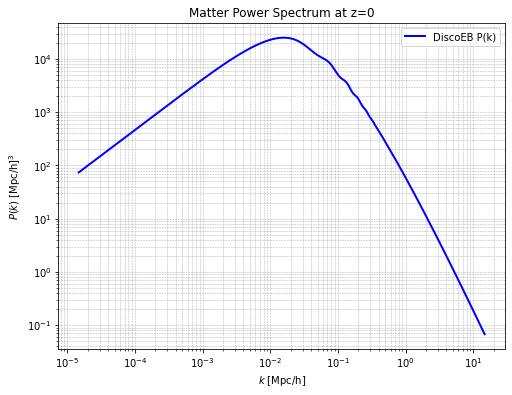

In [6]:
# # Also get the Eisenstein & Hu power spectrum for comparison (from DiscoDJ)
# from discodj import DiscoDJ
# dim = 3
# res = 512
# boxsize = 500.0
# cosmo = {"Omega_c": param['Omegam'] - param['Omegab'],
#          "Omega_b": param['Omegab'],
#          "Omega_k": 0.0,
#          "h": h,
#          "n_s": param['n_s'],
#          "sigma8": 0.8,  # This is a placeholder (would need to be computed based on A_s)
#          "w0": -1.0,
#          "wa": 0.0}

# # Define DISCO-DJ object
# dj = DiscoDJ(dim=dim, res=res, device="gpu", precision="double", cosmo=cosmo, boxsize=boxsize)
# dj = dj.with_timetables()
# dj = dj.with_linear_ps(transfer_function="Eisenstein-Hu")

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(kmodes_in_Mpc_h, Pk_in_Mpc_h, label='DiscoEB P(k)', color='blue', linewidth=2)
# plt.loglog(dj.k[:, 0, 0], dj.evaluate_linear_ps(a=1.0, k=dj.k[:, 0, 0]), label='Eisenstein \& Hu P(k)', color='orange', linestyle='--', linewidth=2)
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('Matter Power Spectrum at z=0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

### Batched over k function

In [2]:
@jax.jit
def compute_matter_power_batched(Omegam=0.3):
    param = {}
    param['Omegam'] = 0.3
    param['Omegab'] = 0.05
    param['w_DE_0'] = -0.99
    param['w_DE_a'] = 0.0
    param['cs2_DE'] = 0.99  # sound speed of DE
    param['Omegak'] = 0.0  # NOTE: Omegak is ignored at the moment!
    param['A_s'] = 2.1e-9
    param['n_s'] = 0.96
    param['H0'] = 67.74  # Hubble constant in km/s/Mpc
    param['Tcmb'] = 2.72548  # CMB temperature in K
    param['YHe'] = 0.248
    Neff = 3.046  # -1 if massive neutrino present
    N_nu_mass = 1.0
    Tnu = (4.0 / 11.0) ** (1.0 / 3.0)
    N_nu_rel = Neff - N_nu_mass * (Tnu / ((4.0 / 11.0) ** (1.0 / 3.0))) ** 4
    param['Neff'] = N_nu_rel
    param['Nmnu'] = N_nu_mass
    param['mnu'] = 0.06  # eV
    param['k_p'] = 0.05  # pivot scale for the primordial power spectrum in Mpc^-1
    param_bg = evolve_background(param=param, thermo_module='RECFAST')

    # Compute perturbations
    y, kmodes = evolve_perturbations_batched(param=param_bg, kmin=1e-5, kmax=1e1, num_k=256,
                        aexp_out=jnp.array([1.0]), lmaxg=11, lmaxgp=11, lmaxr=11, lmaxnu=11,
                        nqmax=3, max_steps=2048, rtol=1e-4, atol=1e-4)

    # Get the power spectrum at z=0
    Pk = get_power(k=kmodes, y=y[:, 0, :], idx=4, param=param_bg)

    # Convert to /h units
    h = param['H0'] / 100.0
    Pk_in_Mpc_h = Pk * h ** 3
    kmodes_in_Mpc_h = kmodes / h
    return Pk_in_Mpc_h, kmodes_in_Mpc_h

In [3]:
Omegam_fid = 0.3
Pk_in_Mpc_h, kmodes_in_Mpc_h = compute_matter_power_batched(Omegam=Omegam_fid)

ValueError: Terms are not compatible with solver! Got:
ODETerm(vector_field=<wrapped function <unnamed function>>)
but expected:
<class 'diffrax.AbstractTerm'>
Note that terms are checked recursively: if you scroll up you may find a root-cause error that is more specific.

In [ ]:
# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.loglog(kmodes_in_Mpc_h, Pk_in_Mpc_h, label='DiscoEB P(k)', color='blue', linewidth=2)
# plt.loglog(dj.k[:, 0, 0], dj.evaluate_linear_ps(a=1.0, k=dj.k[:, 0, 0]), label='Eisenstein \& Hu P(k)', color='orange', linestyle='--', linewidth=2)
plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('Matter Power Spectrum at z=0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

### vmap over Omegam

In [3]:
compute_matter_power_batched = jax.jit(jax.vmap(compute_matter_power))

In [4]:
Omegam_batch = jnp.linspace(0.1, 1, 100)

In [6]:
out = compute_matter_power_batched(Omegam_batch)

In [10]:
out[1].shape

(1000, 256)

In [11]:
kmodes_in_Mpc_h = out[0][0]
kmodes_in_Mpc_h.shape

(256,)

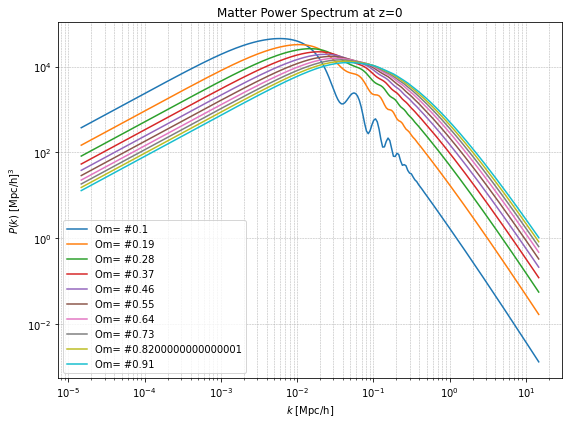

In [35]:
plt.figure(figsize=(8, 6))
Pk_in_Mpc_h_batch = out[0]
kmodes_in_Mpc_h = out[1][1]

for i in range(0, len(Pk_in_Mpc_h_batch), 100):
    Pk = Pk_in_Mpc_h_batch[i]
    plt.loglog(kmodes_in_Mpc_h, Pk, label=f'Om= #{round(Omegam_batch[i], 2)}', linewidth=1.5)
# plt.loglog(kmodes_in_Mpc_h, out[0][0], label=f'Pk #{i}', linewidth=1.5)

plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('Matter Power Spectrum at z=0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Computing the gradients

In [39]:
# might take ~ 2 minutes to compile on first run, ~5s on rerun (RTX3090), 
# increase accuracy (rtol,atol) to reduce noise on derivatives

diff_matter_power = jax.jacfwd(compute_matter_power)
dPkm, _ = diff_matter_power(Omegam_fid)

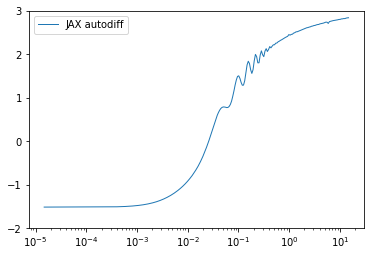

In [46]:
fig, ax = plt.subplots()
# ax.semilogx(kmodes, Omegam_fid * dPkm_fd1, label='finite diff. $\\epsilon=10^{-3}$', alpha=0.75, lw=1)
ax.semilogx(kmodes_in_Mpc_h, Omegam_fid * dPkm / Pk_in_Mpc_h, label='JAX autodiff', lw=1)
# ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
# ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
ax.set_ylim(-2,3)
ax.legend()

In [47]:
diff_matter_power_batched = jax.vmap(diff_matter_power)

In [49]:
dPkm_batch, _ = diff_matter_power_batched(Omegam_batch[:3])

In [50]:
dPkm_batch.shape

(3, 256)

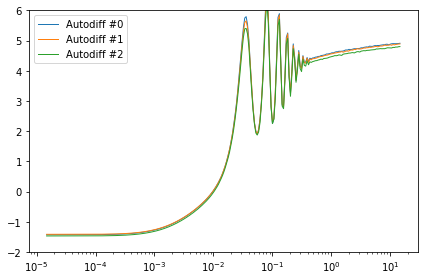

In [54]:
fig, ax = plt.subplots()

# Assume:
# dPkm.shape = (batch_size, num_k)
# Pk_in_Mpc_h.shape = (num_k,)
# kmodes_in_Mpc_h.shape = (num_k,)
# Omegam_fid is a scalar

for i in range(0, len(dPkm_batch)):
    ax.semilogx(
        kmodes_in_Mpc_h,
        Omegam_batch[i] * dPkm_batch[i] / Pk_in_Mpc_h_batch[i],
        label=f'Autodiff #{i}',
        lw=1
    )

ax.set_ylim(-2, 6)
ax.legend()
plt.tight_layout()
plt.show()